# Chapter 4: Reflection
정교한 워크플로우를 사용하더라도 에이전트의 초기 출력이나 계획이 항상 최적화되어 있지 않거나, 정확하지 않거나, 완벽하지 않을 수 있다.
Reflection 패턴이 이때 유용하다.     

자신의 작업, 결과, 내부 상태를 검토하고 그 검증 결과로 성능 개선과 응답을 재정의하는 에이전트를 포함한다. 
self-correction, self-improvement 형태로 에이전트가 반복적으로 자신의 출력을 피드백, 내부 기준 등에 기반해서 검토하고 수정할 수 있다.
Reflection 과정이 초기의 에이전트의 출력을 분석하는데 특화된 별도의 에이전트를 통해 수행되기도 한다.

Reflection 패턴은 피드백 루프를 도입한다. 단순히 결과를 생성하는데 그치지 않고, 자신이 만든 출력을 검토해서 잠재적인 문서나 개선할 부분을 식별한다.
그런 다음, 더 나은 버전을 생성하거나 추후의 행동을 수정한다.

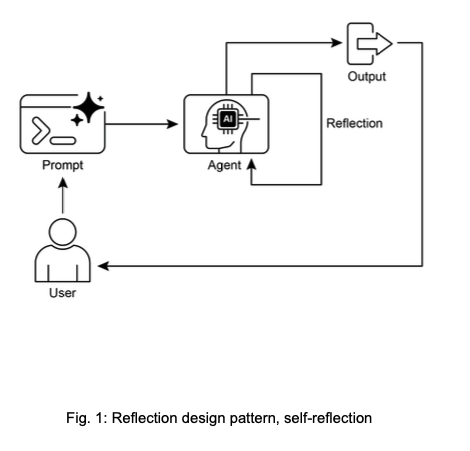

아래의 과정을 가진다.
1. Execution : 태스크를 수행하거나 초기 출력값을 생성한다
2. Evaluation/Critique : 에이전트가 이전 스텝의 결과를 분석. 정확성, 일관성, 스타일, 완전성, 지시사항 준수 또는 다른 기준 들을 점검 할 수 있다.
3. Reflection/Refinement : Critique에 기반해, 에이전트가 어떻게 개선할 지 결정한다. 수정된 결과를 생성하거나, 단순히 파라미터를 조정할 수도 계획 전체를 수정할 수도 있다.
4. Iteration (Optional but common) : 만족할 만한 결과가 생성되거나 종료 조건에 부합될 때 까지 반복될 수 있다

Producer와 Critic. Reflection 프로세스를 두 역할로 분리해서 구현하는 것이 효과적이다. `Generator-Critic`, `Producer-Reviewer`. 싱글 에이전트에 비해 특화 에이전트를 두 개 사용하는 것이 안정적이고 편향되지 않는 결과를 생성한다.

1. The Producer Agent

    초기 프롬프트로 출력의 첫번째 버전을 생성
2. The Critic Agent

    특정 기준에 대한 프로듀서의 작업물 분석을 지시받음. 결점 발견, 개선점 제안, 구조적 피드백 제공

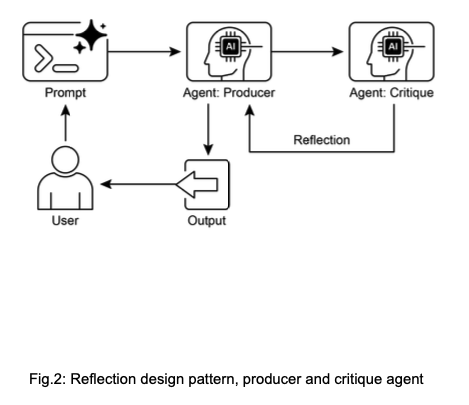


Reflection에서 관심사의 분리는 매우 강력하다. 에이전트가 자신의 태스크를 직접 검토할 때 발생할 수 있는 인지적 편향을 방지할 수 있기 때문이다.     

Reflection 패턴의 효과성은 대화의 기억(memory)을 유지할 때 가장 많이 개선된다. 대화 히스토리는 비평 단계에서 중요한 맥락을 제공해서, 이전 상호작용, 사용자 피드백, 그리고 변화하는 목표를 사용해서 자신의 결과물을 평가할 수 있게 한다. 기억이 있는 경우, Reflection은 누적 프로세스가 되어 더 지능적이고 맥락을 인식하는 개선이 된다.

## Practical Applications & Use Cases

고품질, 정확성, 복잡한 제약 조건 시에 적용하면 좋음

1. 창의적 글쓰기와 컨텐츠 생성
- 블로그 글 작성 에이전트
    - Reflection : 초안 작성 -> 흐름, 톤, 명확성에 대한 비평 -> 재작성

2. 코드 생성과 디버깅
- 파이썬 함수 작성 에이전트
    - Reflection : 코드 작성 -> 테스트, 정적 분석, 에러나 비효율 실별 -> 코드 수정

3. 복잡한 문제 해결
- 논리 퍼즐을 푸는 에이전트
    - Reflection : 스텝 제시 -> 솔루션에 가까워지는지 모순을 유발하는지 평가 -> 백트랙, 다른 스텝 선택

4. 요약 및 정보 통합
- 긴 문서 요약 에이전트
    - 초기 요약문 생성 -> 원문의 핵심 포인트와 비교 -> 요약 수정

5. 계획 및 전략
- 목표 달성을 위한 계획 하는 에이전트
    - 계획 생성 -> 실행 시뮬레이션, 제약 조건에 맞춰 타당성 평가 -> 계획 수정

6. 대화형 에이전트
- 고객 지원 챗봇
    - 사용자 응답 -> 대화 히스토리 리뷰와 마지막 메시지 검토 -> 사용자의 최신 입력 정확히 반영


## reflection loop

In [1]:
from typing import TypedDict, Annotated, Optional, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from llm import LocalLLM

In [2]:
llm = LocalLLM()

In [3]:
# --- 상태 정의 (TypedDict + 리듀서 지정 ) ---
class ReflectionState(TypedDict, total=False):
    task_prompt: str
    messages: Annotated[List[HumanMessage | SystemMessage | AIMessage], add_messages]
    iteration: int
    max_iterations: int
    code: Optional[str]
    critique: Optional[str]

In [4]:
def generate_or_refine(state: ReflectionState) -> ReflectionState:
    """코드 생성 또는 수정 단계..."""
    iteration = state.get("iteration", 0)
    if iteration == 0:
        print(f"\n>>> [반복 {iteration + 1}] 최초 코드 생성 중...")
    else:
        print(f"\n>>> [반복 {iteration + 1}] 코드 수정 중...")

    response = llm.chat(messages=state["messages"])
    code = response

    return {
        "code": code,
        "messages": [AIMessage(content=code)]
    }


def reflect_on_code(state: ReflectionState) -> ReflectionState:
    """코드에 대한 비평 단계..."""
    print("\n>>> 코드에 대한 비평 단계...")

    task = state["task_prompt"]
    code = state["code"] or ""

    reflector_system = SystemMessage(
        content=(
            "당신은 Python 전문가입니다. "
            "제공된 Python 코드를 원본 작업 요구사항에 따라 코드 리뷰하세요. "
            "버그, 스타일 문제, 누락된 엣지 케이스, 개선 여지를 찾으세요. "
            "모든 요구사항을 충족하여 완벽하다고 판단되면 단 하나의 문구만 응답하세요: `PERFECT`."
        )
    )
    human_msg = HumanMessage(
        content=f"원본 작업 요구사항:\n{task}\n\n검토할 코드:\n{code}"
    )

    critique_response = llm.chat(messages=[reflector_system, human_msg])
    critique = critique_response # assume critique_response is string

    if "PERFECT" in critique:
        print("\n--- 비평 ---\n 코드가 완벽하다고 판단되었습니다.")
    else:
        print(f"\n--- 비평 ---\n {critique}")

    return {
        "critique": critique,
        "messages": [HumanMessage(content=f"비평 결과:\n{critique}")]
    }


def check_if_done(state: ReflectionState) -> str:
    """종료 조건 확인 단계..."""
    iteration = state.get("iteration", 0)
    max_iter = state.get("max_iterations", 3)
    critique = state.get("critique", "")

    if ("PERFECT" in critique) or (iteration >= max_iter):
        print("\n 코드가 완벽하거나 최대 반복 횟수에 도달하여 종료합니다.")
        print("\n최종 개선된 코드:\n")
        print(state.get("code", ""))
        return END
    else:
        state["iteration"] = iteration + 1
        return "generate_or_refine"


In [5]:
graph = StateGraph(ReflectionState)
graph.add_node("generate_or_refine", generate_or_refine)
graph.add_node("reflect_on_code", reflect_on_code)
graph.add_node("check_if_done", lambda s: {}) # 실제 함수는 add_conditional_edges에서 사용됨

graph.add_edge(START, "generate_or_refine")
graph.add_edge("generate_or_refine", "reflect_on_code")
graph.add_edge("reflect_on_code", "check_if_done")
graph.add_conditional_edges(
    "check_if_done",
    check_if_done,
    {
        "generate_or_refine": "generate_or_refine",
        END: END,
    }
)

compiled_graph = graph.compile()

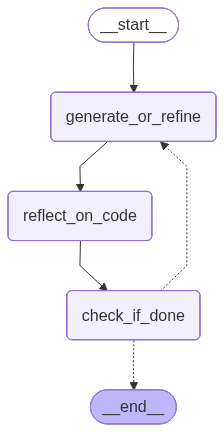

In [6]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [8]:
task_prompt = """
숫자 n을 입력으로 받아 그 팩토리얼(n!)을 계산하는 Python 함수 `calculate_factorial` 을 작성하세요.
요구사항:
1. 정수 n 하나를 입력으로 받습니다.
2. n! 을 계산하여 반환합니다.
3. 함수에 명확한 docstring을 포함하세요.
4. 엣지 케이스: 0의 팩토리얼은 1입니다.
5. 잘못된 입력: 음수 입력 시 ValueError를 발생시켜야 합니다.
"""

initial_state: ReflectionState = {
    "task_prompt": task_prompt,
    "messages": [HumanMessage(content=task_prompt)],
    "iteration": 0,
    "max_iterations": 3,
}
compiled_graph.invoke(initial_state)


>>> [반복 1] 최초 코드 생성 중...

>>> 코드에 대한 비평 단계...

--- 비평 ---
 코드가 완벽하다고 판단되었습니다.

 코드가 완벽하거나 최대 반복 횟수에 도달하여 종료합니다.

최종 개선된 코드:

```python
def calculate_factorial(n):
    """
    Calculate the factorial of a given integer n.

    Parameters:
    n (int): The integer whose factorial is to be calculated.

    Returns:
    int: The factorial of n.

    Raises:
    ValueError: If n is a negative integer.
    """
    if n < 0:
        raise ValueError("Negative numbers do not have factorials.")
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result
```


{'task_prompt': '\n숫자 n을 입력으로 받아 그 팩토리얼(n!)을 계산하는 Python 함수 `calculate_factorial` 을 작성하세요.\n요구사항:\n1. 정수 n 하나를 입력으로 받습니다.\n2. n! 을 계산하여 반환합니다.\n3. 함수에 명확한 docstring을 포함하세요.\n4. 엣지 케이스: 0의 팩토리얼은 1입니다.\n5. 잘못된 입력: 음수 입력 시 ValueError를 발생시켜야 합니다.\n',
 'messages': [HumanMessage(content='\n숫자 n을 입력으로 받아 그 팩토리얼(n!)을 계산하는 Python 함수 `calculate_factorial` 을 작성하세요.\n요구사항:\n1. 정수 n 하나를 입력으로 받습니다.\n2. n! 을 계산하여 반환합니다.\n3. 함수에 명확한 docstring을 포함하세요.\n4. 엣지 케이스: 0의 팩토리얼은 1입니다.\n5. 잘못된 입력: 음수 입력 시 ValueError를 발생시켜야 합니다.\n', additional_kwargs={}, response_metadata={}, id='2045f698-4aab-4df7-a5ff-1f3508a0f549'),
  AIMessage(content='```python\ndef calculate_factorial(n):\n    """\n    Calculate the factorial of a given integer n.\n\n    Parameters:\n    n (int): The integer whose factorial is to be calculated.\n\n    Returns:\n    int: The factorial of n.\n\n    Raises:\n    ValueError: If n is a negative integer.\n    """\n    if n < 0:\n        raise ValueError("Negative numbers do not have factorials.

## Generator-Critic structure

In [27]:
from typing import TypedDict, Annotated, Optional, List, Dict, Literal
from pydantic import BaseModel, Field, ValidationError
import json

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from llm import LocalLLM

In [28]:
llm = LocalLLM()

In [29]:
class SharedState(TypedDict, total=False):
    subject: str
    messages: Annotated[List[HumanMessage | SystemMessage | AIMessage], add_messages]
    draft_text: str
    review_output: Dict[str, str]
    iteration: int
    max_iterations: int

In [30]:
class DraftAgent:
    def __init__(self):
        self.llm = LocalLLM()
        self.graph = self._build_graph()

    def _draft_node(self, state: SharedState) -> SharedState:
        iteration = state.get("iteration", 0) + 1
        subject = state["subject"]

        prev_review = state.get("review_output") or {}
        status = (prev_review.get("status") or "").upper()
        reasoning = prev_review.get("reasoning", "")

        improve_hint = ""
        if status and status != "ACCURATE":
            improve_hint = (
                "\n\n[개선 지시]\n"
                f"- 이전 사실검증에서 발견된 문제: {reasoning}\n"
                "- 위 문제를 모두 수정하여 더 정확한 단락을 작성하세요."
            )

        prompt = (
            "다음 주제에 대한 짧고 정보성 있는 단락을 한국어로 작성하세요.\n"
            "- 과장 없이 핵심만 4~5문장으로 정리하세요.\n"
            f"- 주제: {subject}"
            f"{improve_hint}"
        )

        draft_text = self.llm.chat(
            messages=state["messages"] + [HumanMessage(content=prompt)]
        )

        return {
            "iteration": iteration,
            "draft_text": draft_text,
            "messages": [
                AIMessage(content=draft_text),
                HumanMessage(content="위 초안에 대해 사실 검증 해주세요.")
            ],
        }

    def _build_graph(self):
        g = StateGraph(SharedState)
        g.add_node("DraftNode", self._draft_node)
        g.add_edge(START, "DraftNode")
        g.add_edge("DraftNode", END)
        return g.compile()

In [31]:
class ReviewModel(BaseModel):
    status: Literal["ACCURATE", "INACCURATE"] = Field(..., description="정확성에 대한 비평")
    reasoning: str = Field(..., min_length=1, description="비평 이유 설명")


class CriticAgent:
    def __init__(self):
        self.llm = LocalLLM()
        self.graph = self._build_graph()

    def _review_node(self, state: SharedState) -> SharedState:
        draft = state.get("draft_text", "")
        system_msg = SystemMessage(content=(
            "당신은 세심한 사실검증가입니다. 제공된 텍스트의 사실 정확성을 검토하세요. "
            '최종 출력은 다음 두 키만 포함하는 JSON이어야 합니다: '
            '{"status":"ACCURATE"|"INACCURATE","reasoning":"<검토 근거>"}'
        ))
        user_msg = HumanMessage(content=f"검토할 텍스트:\n{draft}")

        review_dict: Dict[str, str] | None = None

        structured = self.llm.with_structured_output(ReviewModel)
        result: ReviewModel = structured.invoke(
            state["messages"] + [system_msg, user_msg]
        )
        review = result.model_dump()

        return {
            "review_output": review,
            "messages": [AIMessage(content=result.model_dump_json())]
        }


    def _build_graph(self):
        g = StateGraph(SharedState)
        g.add_node("ReviewNode", self._review_node)
        g.add_edge(START, "ReviewNode")
        g.add_edge("ReviewNode", END)
        return g.compile()

In [32]:
def supervisor_node(state: SharedState) -> SharedState:
    """종료 조건 확인 단계..."""
    status = (state.get("review_output") or {}).get("status", "")
    it = state.get("iteration", 0)
    log = f"[Supervisor] status={status}, iteration={it}"
    return {"messages": [HumanMessage(content=log)]}


def route_from_supervisor(state: SharedState) -> str:
    status = (state.get("review_output") or {}).get("status", "")
    status = status.upper()   # 정규화
    it = state.get("iteration", 0)
    max_it = state.get("max_iterations", 3)

    # 부정확 && 반복 한도 미만 → Draft로 루프, 그 외는 종료
    if status != "ACCURATE" and it < max_it:
        return "GeneratorAgent"
    return END

In [33]:
def build_orchestrator_graph(
    generator_graph,
    critic_graph
):
    parent = StateGraph(SharedState)

    parent.add_node("GeneratorAgent", generator_graph)
    parent.add_node("CriticAgent", critic_graph)
    parent.add_node("Supervisor", supervisor_node)

    parent.add_edge(START, "GeneratorAgent")
    parent.add_edge("GeneratorAgent", "CriticAgent")
    parent.add_edge("CriticAgent", "Supervisor")
    parent.add_conditional_edges(
        "Supervisor",
        route_from_supervisor,
        {
            "GeneratorAgent": "GeneratorAgent",
            END: END,
        }
    )
    return parent.compile(checkpointer=MemorySaver())


In [34]:
draft_agent = DraftAgent()
critic_agent = CriticAgent()

# 부모 그래프 빌드
graph = build_orchestrator_graph(
    generator_graph=draft_agent.graph,
    critic_graph=critic_agent.graph
)

# 초기 상태: messages는 반드시 초기화 (히스토리 누적 기준)
initial: SharedState = {
    "subject": "잠에 대한 대한민국의 사투리",
    "messages": [HumanMessage(content="주제: 졸리다와 잠이온다의 차이에 대해서 설명해줘")],
    "iteration": 0,
    "max_iterations": 3,
}

# 동일 thread_id로 여러 번 호출하면 상태/히스토리가 복원됩니다.
config = {"configurable": {"thread_id": "modular-supervised-loop-1"}}

final_state = graph.invoke(initial, config)

print("\n=== 최종 결과 ===")
print("반복(iteration):", final_state.get("iteration"))
print("\n초안(draft_text):\n", final_state.get("draft_text", ""))
print("\n리뷰(review_output):\n", final_state.get("review_output", {}))


=== 최종 결과 ===
반복(iteration): 1

초안(draft_text):
 한국어 사투리에서 '졸리다'는 피로감을 나타내는 표현이고, '잠이온다'는 잠이 오는 상태를 의미한다. '졸리다'는 주로 피로를 느끼는 경우에 쓰이며, '잠이온다'는 잠이 들어가는 순간을 표현한다. 두 표현은 모두 잠에 대한 감정을 나타내지만, '졸리다'는 더 구체적인 피로감을, '잠이온다'는 잠이 오는 과정을 강조한다. 일상 대화에서 '잠이온다'는 더 자연스럽게 사용되며, '졸리다'는 더 정확한 상태를 나타내는 표현이다.

리뷰(review_output):
 {'status': 'ACCURATE', 'reasoning': "텍스트는 '졸리다'가 피로감을 나타내는 표현이고 '잠이온다'가 잠이 오는 상태를 의미하는 것에 대해 정확하게 설명했습니다. 두 단어의 차이를 명확히 정의하고, 일상적 사용 상황도 올바르게 설명되어 있습니다."}


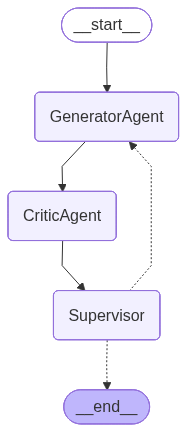

In [35]:
display(Image(graph.get_graph().draw_mermaid_png()))